Cat and Dog image classifier.

Dataset source: [https://www.microsoft.com/en-us/download/details.aspx?id=54765](https://www.microsoft.com/en-us/download/details.aspx?id=54765)

Tutorial being followed: [https://youtu.be/gT4F3HGYXf4](https://youtu.be/gT4F3HGYXf4)

Python3.8

### Part 1: Load, process, and organize the data set.

In [1]:
# Dependencies.

!apt-get update
!apt-get install ffmpeg libsm6 libxext6  -y
!pip install opencv-python matplotlib numpy tensorflow

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease             
Hit:3 http://archive.ubuntu.com/ubuntu focal-backports InRelease           
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:5 http://security.ubuntu.com/ubuntu focal-security InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Release
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsm6 

In [2]:
from dataclasses import dataclass
import cv2
import numpy as np
import os
from typing import List

DATA_DIRECTORY = '/data-sets/PetImages'
PICKLED_DATA = '/pickled-data'
MODELS_SAVING_LOCATION = '/models'
CATEGORIES = ['Dog', 'Cat']
IMG_SIZE = 50

Small data structure to neatly store features and labels and keep things type safe.

In [3]:
@dataclass
class Data:
    feature: np.ndarray
    label: int

In [4]:
def create_training_dataset(date_set_path: str, img_size: int = 100) -> List[Data]:
    """
    :param date_set_path:
    :param img_size:
    :return: List of encoded data set with labels - List[List[np.ndarray, int]]

    Loops over the 'Dog' and 'Cat' folders in the data set and returns them as a list with their labels.
    """

    encoded_data_set: List[Data] = []

    for category in CATEGORIES:
        path_to_image: str = os.path.join(date_set_path, category)
        class_num: int = CATEGORIES.index(category)

        for img in os.listdir(path_to_image):
            try:
                # Encode data and resize image.
                img_array: np.ndarray = cv2.imread(os.path.join(path_to_image, img), cv2.IMREAD_GRAYSCALE)
                resized_img: np.ndarray = cv2.resize(img_array, (img_size, img_size))

                # Image array, and it's label.
                encoded_data_set.append(Data(resized_img, class_num))

            except Exception:  # A few images are causing an issue, we are just ignoring these.
                pass

    return encoded_data_set

In [5]:
training_data: List[Data] = create_training_dataset(DATA_DIRECTORY, IMG_SIZE)

print(len(training_data))  # Check if training_date is populated.

24946


In [6]:
import random

random.shuffle(training_data)


Uppercase 'X' typically are the features, and lower case 'y' are the labels.

In [7]:
X: List[np.ndarray] = []
y: List[int] = []

for data in training_data:
    X.append(data.feature)
    y.append(data.label)

# -1 in this case means any number of images. The last number is 1 because we converted the images into gray scale.
X: np.ndarray = np.array(X).reshape((-1, IMG_SIZE, IMG_SIZE, 1))
y: np.ndarray = np.array(y)

Use pickle to store processed, and organized dataset.

In [8]:
import pickle

with open(f'{PICKLED_DATA}/X.pickle', 'wb') as file:
    pickle.dump(X, file)

with open(f'{PICKLED_DATA}/y.pickle', 'wb') as file:
    pickle.dump(y, file)

### Part 2: Build and train the model.

In [9]:
# Use pickle to load the saved data.

with open(f'/{PICKLED_DATA}/X.pickle', 'rb') as file:
    X: np.ndarray = pickle.load(file)
    X = X / 255.0  # Normalize the data.

with open(f'/{PICKLED_DATA}/y.pickle', 'rb') as file:
    y: List[np.ndarray] = pickle.load(file)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from time import time

Training a number of models.

In [11]:
# Model configurations.
dense_layers = [0]
layer_sizes = [64]
conv_layers = [3]
history = None

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME: str = f'{conv_layer}-conv-{layer_size}-nodes-{dense_layer}-dense-{int(time())}'
            print(NAME)

            # Set up tensorboard logs.
            tensorboard = TensorBoard(
                log_dir=f'/tensorboard-logs/{NAME}'
            )

            model = Sequential()
            model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:], activation=relu))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            # Add convolution layers.
            for i in range(conv_layer - 1):
                model.add(Conv2D(layer_size, (3, 3), activation=relu))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            # Add Dense Layers.
            for i in range(dense_layer):
                model.add(Dense(512, activation=relu))

            model.add(Dense(1, activation=sigmoid))

            model.compile(
                loss=BinaryCrossentropy(),
                optimizer=Adam(),
                metrics=['accuracy']
            )

            # Train model.
            history = model.fit(
                X,
                y,
                batch_size=32,
                validation_split=0.3,
                epochs=10,
                callbacks=[
                    tensorboard
                ]
            )

            model.save(f'{MODELS_SAVING_LOCATION}/cat_dog_classier.model')

3-conv-64-nodes-0-dense-1636389079
Epoch 1/10
546/546 [==============================] - 5s 7ms/step - loss: 0.6440 - accuracy: 0.6212 - val_loss: 0.6068 - val_accuracy: 0.6629
Epoch 2/10
546/546 [==============================] - 3s 6ms/step - loss: 0.5680 - accuracy: 0.7098 - val_loss: 0.5362 - val_accuracy: 0.7305
Epoch 3/10
546/546 [==============================] - 3s 6ms/step - loss: 0.5031 - accuracy: 0.7556 - val_loss: 0.5300 - val_accuracy: 0.7322
Epoch 4/10
546/546 [==============================] - 3s 6ms/step - loss: 0.4684 - accuracy: 0.7822 - val_loss: 0.4884 - val_accuracy: 0.7626
Epoch 5/10
546/546 [==============================] - 3s 6ms/step - loss: 0.4408 - accuracy: 0.7947 - val_loss: 0.4654 - val_accuracy: 0.7779
Epoch 6/10
546/546 [==============================] - 3s 6ms/step - loss: 0.4157 - accuracy: 0.8112 - val_loss: 0.4584 - val_accuracy: 0.7842
Epoch 7/10
546/546 [==============================] - 3s 6ms/step - loss: 0.3935 - accuracy: 0.8225 - val_loss: 0

In [12]:
history_dict = history.history

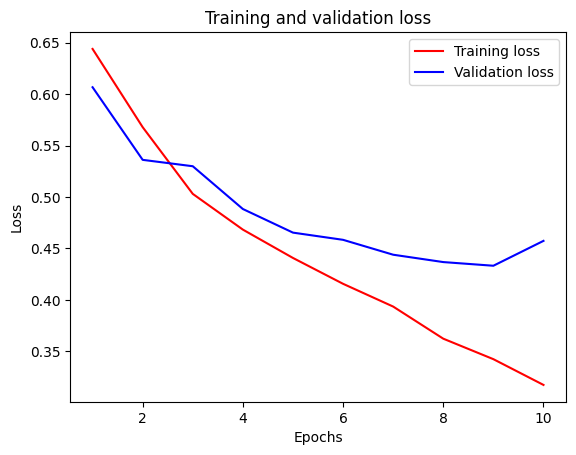

In [13]:
from matplotlib import pyplot as plt

loss: list = history_dict['loss']
val_loss: list = history_dict['val_loss']
epochs = range(1, len(loss) + 1)

red_line = 'ro'
blue_line = 'b'


plt.clf()
plt.plot(epochs, loss, red_line, label='Training loss')
plt.plot(epochs, val_loss, blue_line, label='Validation loss')
plt.axhline(y=1)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

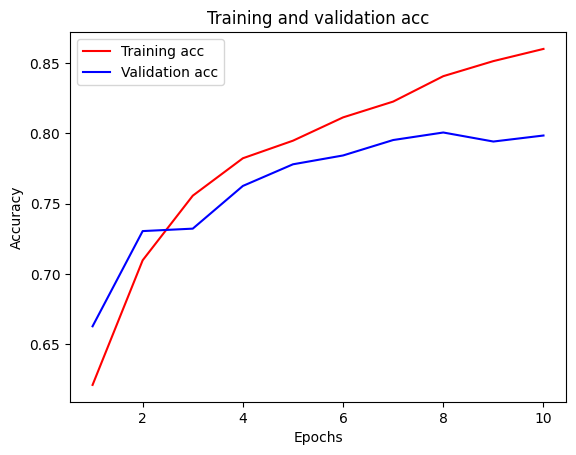

In [14]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(acc) + 1)

red_line = 'ro'
blue_line = 'b'

plt.clf()
plt.plot(epochs, acc, red_line, label='Training acc')
plt.plot(epochs, val_acc, blue_line, label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()